<div style="background: navy; color: white; padding: 20px">


# $\S 5$: Market Regime Detection with Rough Path Signatures: Motivating examples

In this notebook, we step through the examples shown in Section 5 of the paper "Market Regime Detection with Rough Path Signatures". 

### Background.

<div style="background: navy; color: white; padding: 20px">

### Imports

In [1]:
import numpy as np

from src.generators.config import ModelConfig
from src.testing import TestConfig
from src.testing.discriminators import GeneralMMDDetector
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.mmd_test_functions import alpha_score_function, get_beliefs_from_config
from src.testing.experiment_functions.plot_result_functions import plot_path_experiment_result, plot_path_test_threshold
from src.utils.Config import Config
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.auxiliary_classes.RegimePartitioner import RegimePartitioner, RegimePartitionerConfig
from src.utils.helper_functions.plot_helper_functions import plot_regime_change_path, plot_scores, plot_beliefs
from src.utils.helper_functions.test_helper_functions import get_memberships, get_alphas, get_sub_paths, \
    get_grouped_paths

np.random.seed(1)

### $\S 5.1$ Synthetic, single-class beliefs.

In this section of the notebook, we test the MMD online detector with some synthetic examples. Here we only define one set of beliefs held by the user. 


#### Choice of models.
One is able to choose from the models <code>["gbm", "merton", "rBergomi", "heston", "rough_heston"]</code>. See the documentation for how the parameter vectors are defined. 

#### Choice of detection algorithms. 

We provide two main types of detection algorithms: those with parametric beliefs, non-parametric beliefs, or progressive (auto-updating) beliefs, where beliefs are built as the test path is observed. 

<b> I need to flesh this out and update it.</b>

<div style="background: navy; color: white; padding: 20px">

## 1. Set configurations

Here, choose the configuration one wishes to use to run the experiment. 

Configurations to do with - 
1. Testing (number of paths, path lengths, types of paths...) are located in <code>TestConfig</code>, 
2. Discriminator processes (type of algorithm and associated hyperparameters) are located in <code>ProcessorConfig</code>, 
3. Path generation arguments (size of mesh per year, and whether to attach volatility process or not) are located in <code>ModelConfig</code>,
4. Path transformation arguments are located in <code>PathTransformerConfig</code>, and 
5. Synthetic regime change partitioning arguments are located in <code>RegimePartitionerConfig</code>.

In [2]:
# Set configs
test_config             = TestConfig()
model_config            = ModelConfig()
path_transformer_config = PathTransformerConfig()
processor_config        = ProcessorConfig()
regime_config           = RegimePartitionerConfig()


model_config.override_args({
    "year_mesh": 7*252,
    "attach_volatility": True
})


T   = 4                         # Time to simulate regime-changed path until
dim = 10                        # Dimensionality of simulated paths 
S0  = [1. for _ in range(dim)]  # Initial value of simulated paths
dt  = 1/model_config.year_mesh  # Size of path increment
 
n_model_pairs     = 1
low_vol           = 0.2
high_vol          = 0.3
rc_params         = np.linspace(low_vol, high_vol, n_model_pairs)
std_regime_params = [0.2 for _ in range(n_model_pairs)]
all_params        = np.zeros(2*n_model_pairs)
all_params[::2]   = std_regime_params
all_params[1::2]  = rc_params
rc_param_vector   = [[[0., v] for _ in range(dim)] for v in all_params]
#rc_params     = [high_vol]


rB_params_h0  = [0.03, 0.5, -0.7, 0.4]
rB_params_h1  = [0.03, 0.5, -0.7, 0.3]


test_config.override_args({
    "n_steps": 16,
    "n_paths": 8,
    "offset" : 0,
    "weight_factor": 1,
    "belief_models": ["rBergomi"],
    "model_pair_names": ["rBergomi", "rBergomi"],
    "belief_params": [[rB_params_h0 for _ in range(dim)]],
    "model_pair_params": [[rB_params_h0 for _ in range(dim)], [rB_params_h1 for _ in range(dim)]],
    "path_bank_size": 100000
})

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True , 0, {"s_type": "initial"}),
    "time_normalisation_transform":  (True , 0, {}),
    "time_difference_transform":     (False, 0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False , 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [(1/dt)**0.5 for _ in range(dim)]}),
    "cumulant_transform":            (False , 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})


path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8

processor_config.override_args({
    "generalmmddetector_kwargs": Config(**{
        "n_tests": 512,
        "n_evaluations": 1,
        "metric_kwargs": Config(**{
            "kernel_type": "linear",
            "metric_type": "mmd",
            "sigmas": [2.5e-1],  
            "dyadic_orders": [2],  
            "lambd": 5
        }),
        "evaluator_kwargs": Config(**{
            "pct_ignore": 0.1
        })
    }),
    "autoevaluator_kwargs": Config(**{
        "metric_kwargs": Config(**{
            "sigmas": [0.025],
            "dyadic_orders": [3],
            "lambd": 5
        }),
        "n_scores": 50,
        "evaluator_kwargs": Config(**{
            "lags": [-1]
        })
    }),
    "alpha_value": 0.95,
    "device": "cuda:0",
    "overwrite_prior": True
})


regime_config.override_args({
    "n_regime_changes": 5,
    "f_length_scale"  : 0.5, 
    "type"            : "random_on_off_steps", 
    "r_on_args"       : ["poisson", 2],
    "r_off_args"      : ["poisson", 1/30],
    "r_min_distance"  : 16,
    "r_min_gap"       : 16
})

path_transformer = PathTransformer(path_transformer_config)

<div style="background: navy; color: white; padding: 20px">

## 2. Derive beliefs and initialize detector

We first derive our (parametric) beliefs $\mathfrak{P} = (\mathfrak{P}_1, \dots, \mathfrak{P}_k)$. One can increase the number of beliefs by changing the <code>belief_models</code> and associated <code>belief_params</code> in the <code>TestConfig</code> object.

We can then generate our null beliefs $\mathfrak{D} = (\mathfrak{D}_1, \dots, \mathfrak{D}_k)$ and associate these to a <code>Detector</code> object, which uses the MMD with the specified scaling and static kernel as a metric on path space to detect different regimes.

In [3]:
beliefs, belief_details, model_pairs = get_beliefs_from_config(test_config, model_config, overwrite=False)

In [4]:
# Instantiate Detector object
general_detector = GeneralMMDDetector(
    beliefs          = beliefs, 
    path_details     = belief_details,
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

100%|██████████| 100000/100000 [00:20<00:00, 4775.02it/s]


Metric initialized. MMD1, kernel = linear, dyadic_order = 2


0it [00:00, ?it/s]c:\users\zacha\dropbox\kings-work\project-code\mmd-goursat-problem\venv\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
512it [00:02, 200.05it/s]


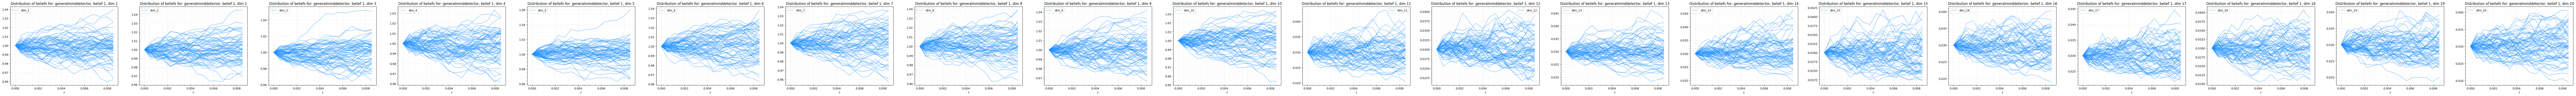

In [5]:
# Plot belief paths
plot_beliefs(general_detector, reverse=False, transformed=False)

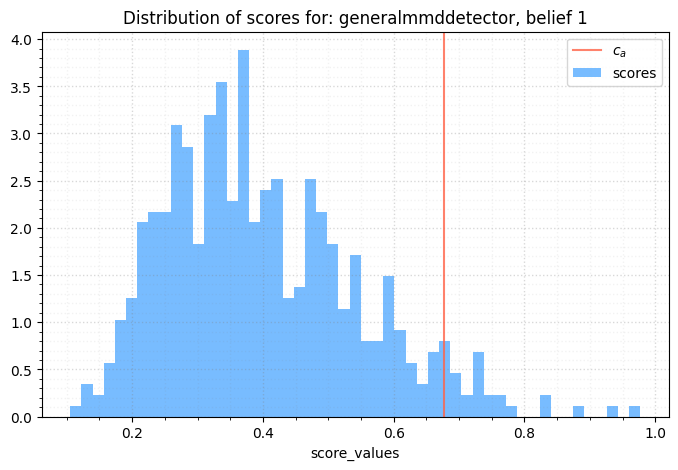

In [6]:
# Show beliefs as histogram(s)
plot_scores(general_detector, reverse=False)

<div style="background: navy; color: white; padding: 20px">


### 3. Build test detection path

In [7]:
# Generate path for testing
regime_partitioner = RegimePartitioner(model_config.year_mesh, regime_config)
regime_partitioner.generate_regime_partitions(T=T, n_steps=test_config.n_steps)
test_path = regime_partitioner.generate_regime_change_path(model_pairs, S0)

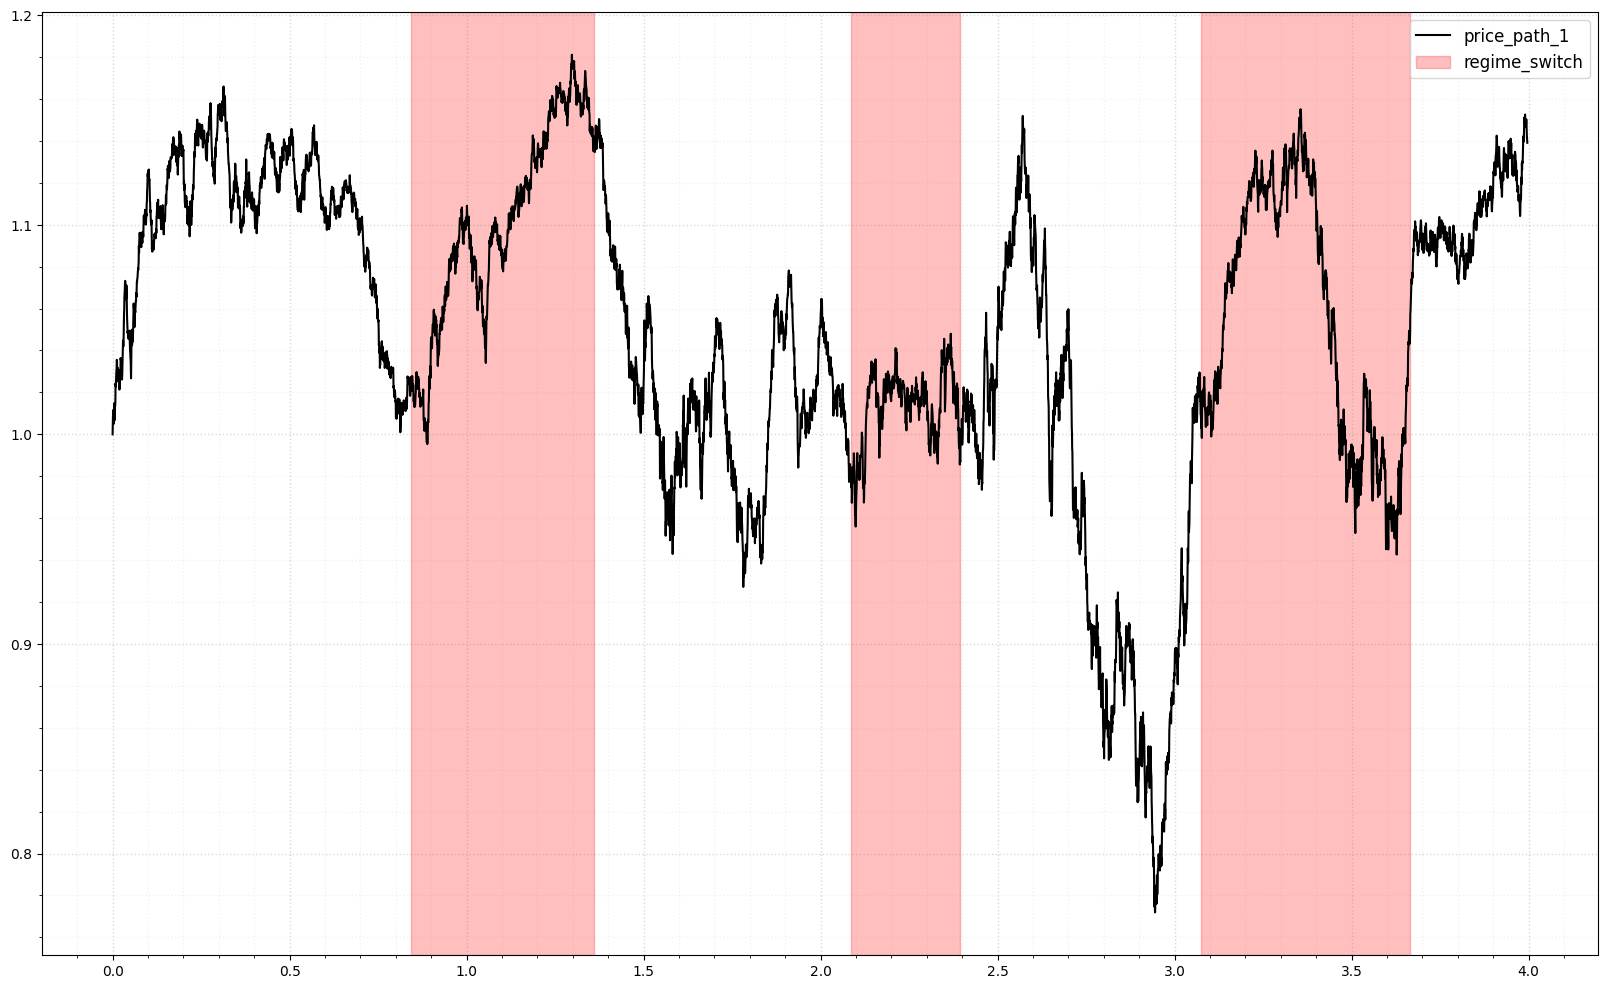

In [8]:
_, regime_changes, _ = regime_partitioner.changes_to_times()

plot_regime_change_path(test_path, regime_changes, log_returns=False, one_dim=True)

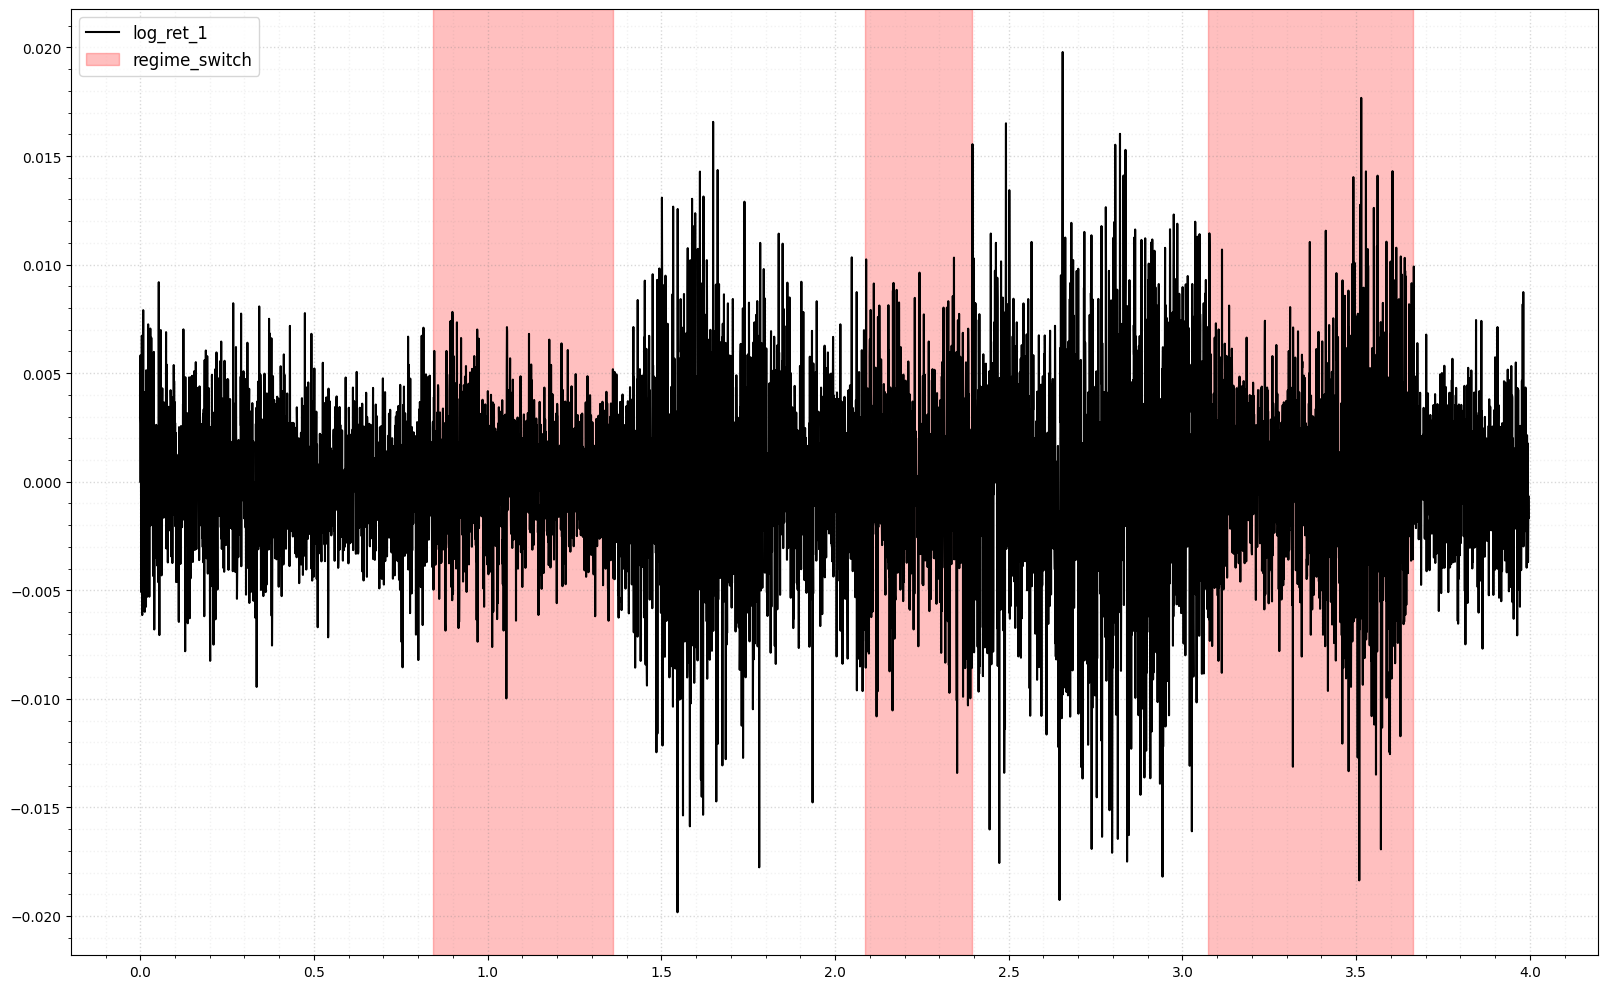

In [9]:
plot_regime_change_path(test_path, regime_changes, log_returns=True, one_dim=True)

<div style="background: navy; color: white; padding: 20px">


### 4. Run Detector over generated path

In [10]:
general_scores_array = general_detector.evaluate_path(test_path, evaluation="total")

100%|██████████| 434/434 [00:01<00:00, 279.57it/s]


In [11]:
general_scores_array.shape

(2, 434)

<div style="background: navy; color: white; padding: 20px">


### 5. Plot and report results

In [85]:
# Extract sub paths for score functions 
sub_paths = get_sub_paths(test_path, test_config.n_steps, test_config.offset)
c_alpha_g = general_detector.critical_value

# Get alpha scores for test thresholds
if processor_config.generalmmddetector_kwargs.metric_kwargs.metric_type == "mmd":
    _n_paths      = test_config.n_paths
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    memberships   = get_memberships(mmd_paths)
    mmd_alphas_g  = get_alphas(memberships, general_scores_array, c_alpha_g)
else:
    _n_paths      = 1
    memberships   = np.array([[i] for i in range(sub_paths.shape[0])])
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    #mmd_alphas_g  = 1.0*np.array([gsc >= cv[0] for gsc, cv in zip(general_scores_array[1:], c_alpha_g)])
    mmd_alphas_g  = np.array([general_scores_array[1, :] - general_scores_array[2, :] >= 0]).astype(float)

path_splits_time = [item for sublist in [[r[0], r[1] + 1/model_config.year_mesh] for r in regime_changes] for item in sublist] 
path_splits_mesh = [int(p*model_config.year_mesh) for p in path_splits_time]

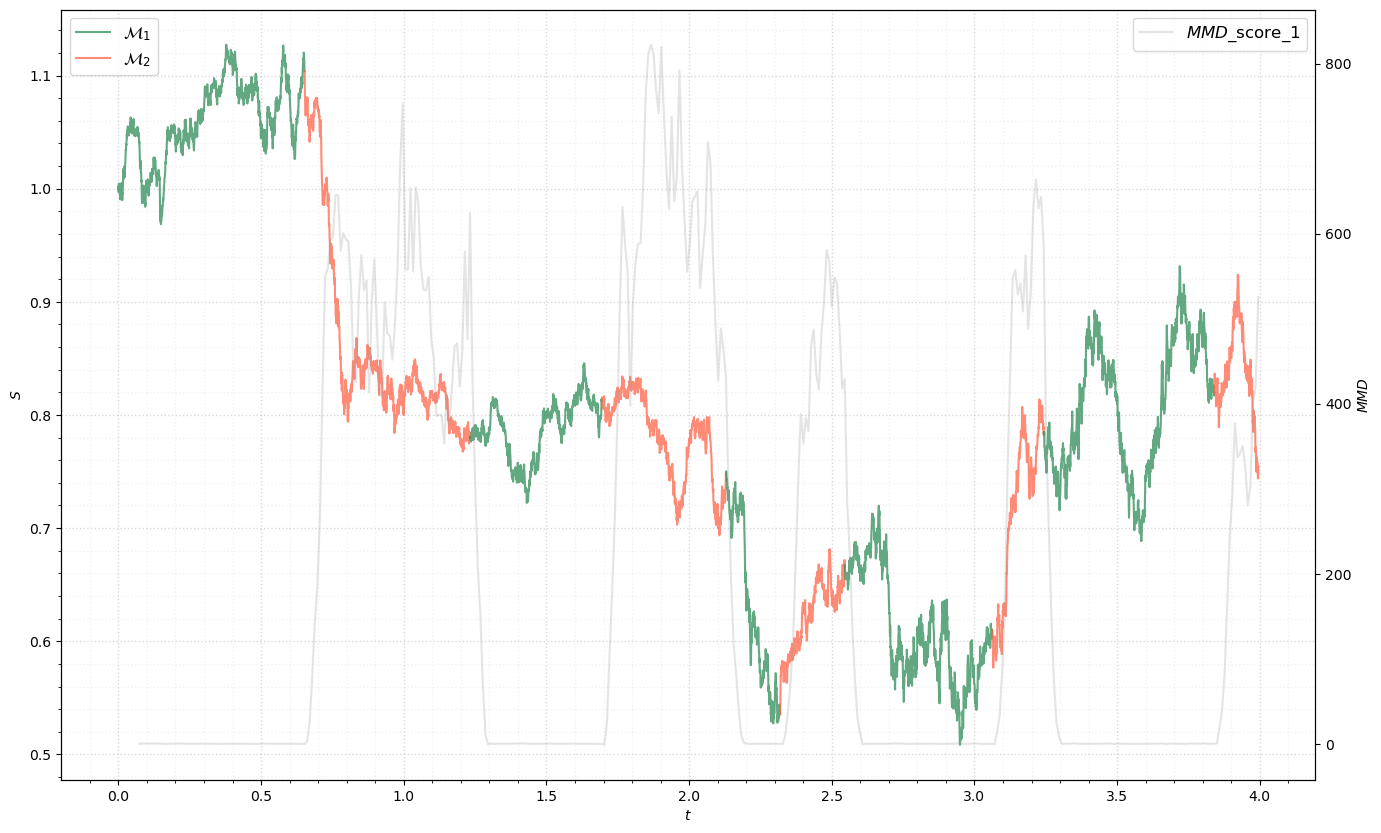

In [86]:
# Plot MMD scores
if processor_config.generalmmddetector_kwargs.metric_kwargs.metric_type == "scoring":
    index = general_scores_array[0, :]
    this_score_array = np.vstack([index, general_scores_array[1, :] - general_scores_array[2, :]])
    
    plot_path_experiment_result(test_path, this_score_array, path_splits_mesh, diff=False)
else:
    plot_path_experiment_result(test_path, general_scores_array, path_splits_mesh, diff=False)

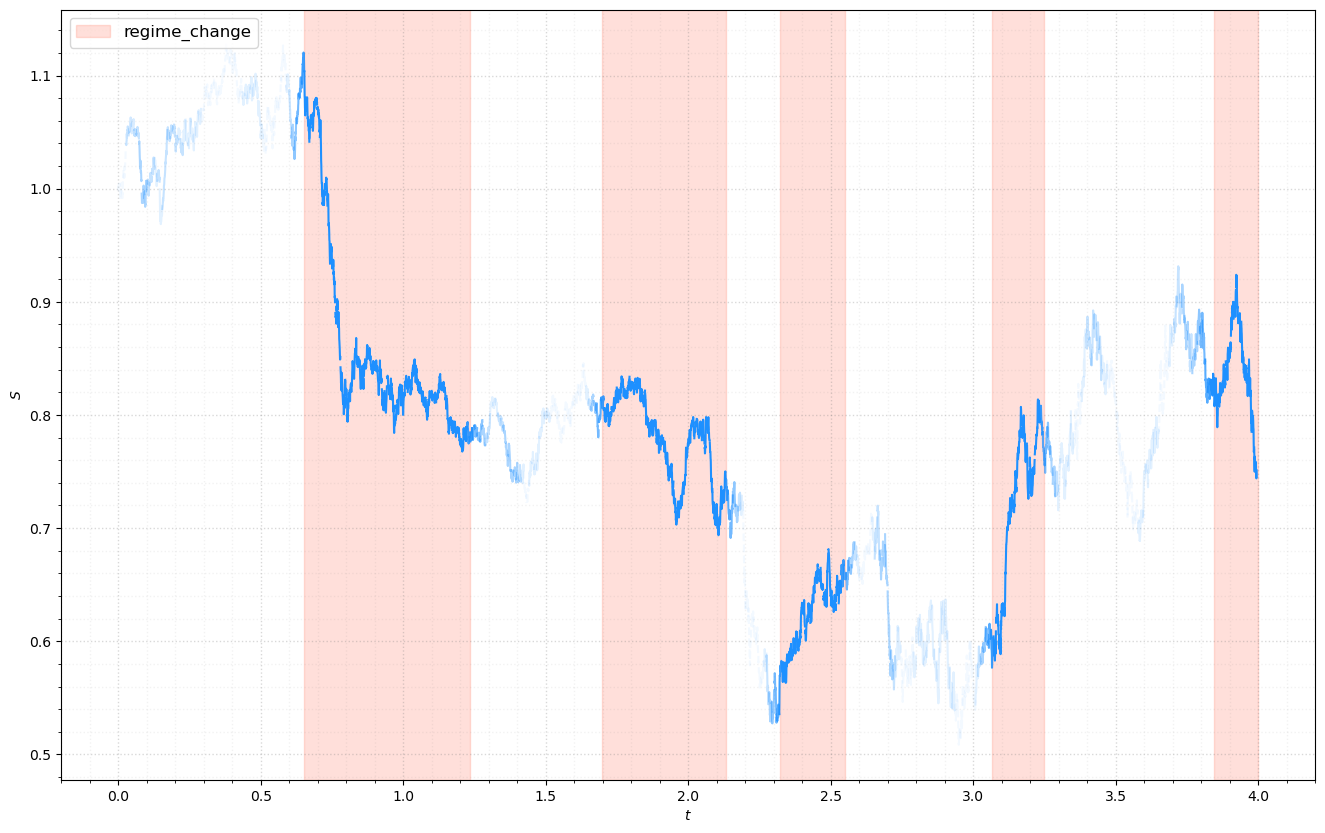

In [93]:
# Plot test threshold performance
for alphas in mmd_alphas_g:
    plot_path_test_threshold(sub_paths, alphas, path_splits_time, one_dim=True)

In [94]:
general_scores_dict = alpha_score_function(
    regime_changes = regime_partitioner.regime_changes, 
    path_length    = len(test_path), 
    memberships    = memberships,
    test_alphas    = mmd_alphas_g[0].astype(bool) ,
    test_data      = [test_config.n_steps, test_config.offset, _n_paths]
)

print("General_MMD_Detector scores")
for k, v in general_scores_dict.items():
    print("{}: {:.4f}%".format(k, v*100))

General_MMD_Detector scores
regime_on: 75.0527%
regime_off: 41.6667%
total: 59.6088%


<div style="background: navy; color: white; padding: 20px">

    
### $\S 5.2$: An example of multiclass beliefs

Here, we show how multi-class beliefs are used, with a simple toy example. 

In particular we set three different kinds of beliefs: low-, medium- and high-volatilty, corresponding to volatility parameters $\sigma_1 < \sigma_2 < \sigma_3$. We then construct a regime path by uniformly sampling over $[\sigma_1, \sigma_3]$ and compare the corresponding MMD/scoring rule values against each of the beliefs. 

This section follows in the same way as the steps above.

In [15]:
# Set configs
test_config             = TestConfig()
model_config            = ModelConfig()
path_transformer_config = PathTransformerConfig()
processor_config        = ProcessorConfig()
regime_config           = RegimePartitionerConfig()


model_config.override_args({
    "year_mesh": 7*252,
    "attach_volatility": False
})


T   = 10                        # Time to simulate regime-changed path until
dim = 1                         # Dimensionality of simulated paths 
S0  = [1. for _ in range(dim)]  # Initial value of simulated paths
dt  = 1/model_config.year_mesh  # Size of path increment

n_model_pairs = 10
low_vol       = 0.1
med_vol       = 0.2
high_vol      = 0.4
rc_params     = np.linspace(low_vol, high_vol, n_model_pairs)
#rc_params     = np.random.uniform(low_vol, high_vol, n_model_pairs)

std_regime_params = [0.2 for _ in range(n_model_pairs)]
all_params        = np.zeros(2*n_model_pairs)
all_params[::2]   = std_regime_params
all_params[1::2]  = rc_params
 
test_config.override_args({
    "n_steps": 8,
    "n_paths": 16,
    "offset" : 0,
    "weight_factor": 1,
    "belief_models": ["gbm", "gbm", "gbm"],
    "model_pair_names": ["gbm" for _ in range(2*n_model_pairs)],
    "belief_params": [[[0., low_vol] for _ in range(dim)], [[0., med_vol] for _ in range(dim)], [[0., high_vol] for _ in range(dim)]],
    "model_pair_params": [[[0., vol] for _ in range(dim)] for vol in all_params],
    "path_bank_size": 100000
})

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True,  0, {"s_type": "initial"}),
    "time_normalisation_transform":  (True,  0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False, 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [np.power((1/dt), 5e-1) for _ in range(dim)]}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})

path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8

processor_config.override_args({
    "generalmmddetector_kwargs": Config(**{
        "n_tests": 512,
        "n_evaluations": 1,
        "metric_kwargs": Config(**{
            "kernel_type": "linear",
            "metric_type": "mmd",
            "sigmas": [1e0],  
            "dyadic_orders": [2],  
            "lambd": 5
        }),
        "evaluator_kwargs": Config(**{
            "pct_ignore": 0.1
        })
    }),
    "autoevaluator_kwargs": Config(**{
        "metric_kwargs": Config(**{
            "sigmas": [0.025],
            "dyadic_orders": [3],
            "lambd": 5
        }),
        "n_scores": 50,
        "evaluator_kwargs": Config(**{
            "lags": [-1]
        })
    }),
    "alpha_value": 0.95,
    "device": "cuda:0",
    "overwrite_prior": True
})


regime_config.override_args({
    "n_regime_changes": 5,
    "f_length_scale"  : 0.5, 
    "type"            : "random_on_off_steps", 
    "r_on_args"       : ["poisson", 2],
    "r_off_args"      : ["poisson", 1/64],
    "r_min_distance"  : 20,
    "r_min_gap"       : 20
})

path_transformer = PathTransformer(path_transformer_config)

In [3]:
beliefs, belief_details, model_pairs = get_beliefs_from_config(test_config, model_config, overwrite=False)

In [4]:
# Instantiate Detector object
sigker_detector = GeneralMMDDetector(
    beliefs          = beliefs, 
    path_details     = belief_details,
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

100%|██████████| 100000/100000 [00:01<00:00, 82234.50it/s]


Metric initialised. MMD1, sigma = 1.0000, dyadic_order = 2


512it [00:05, 90.99it/s] 
512it [00:01, 406.08it/s]
512it [00:01, 362.33it/s]


In [5]:
# Generate path for testing
regime_partitioner = RegimePartitioner(model_config.year_mesh, regime_config)
regime_partitioner.generate_regime_partitions(T=T, n_steps=test_config.n_steps)
test_path = regime_partitioner.generate_regime_change_path(model_pairs, S0)

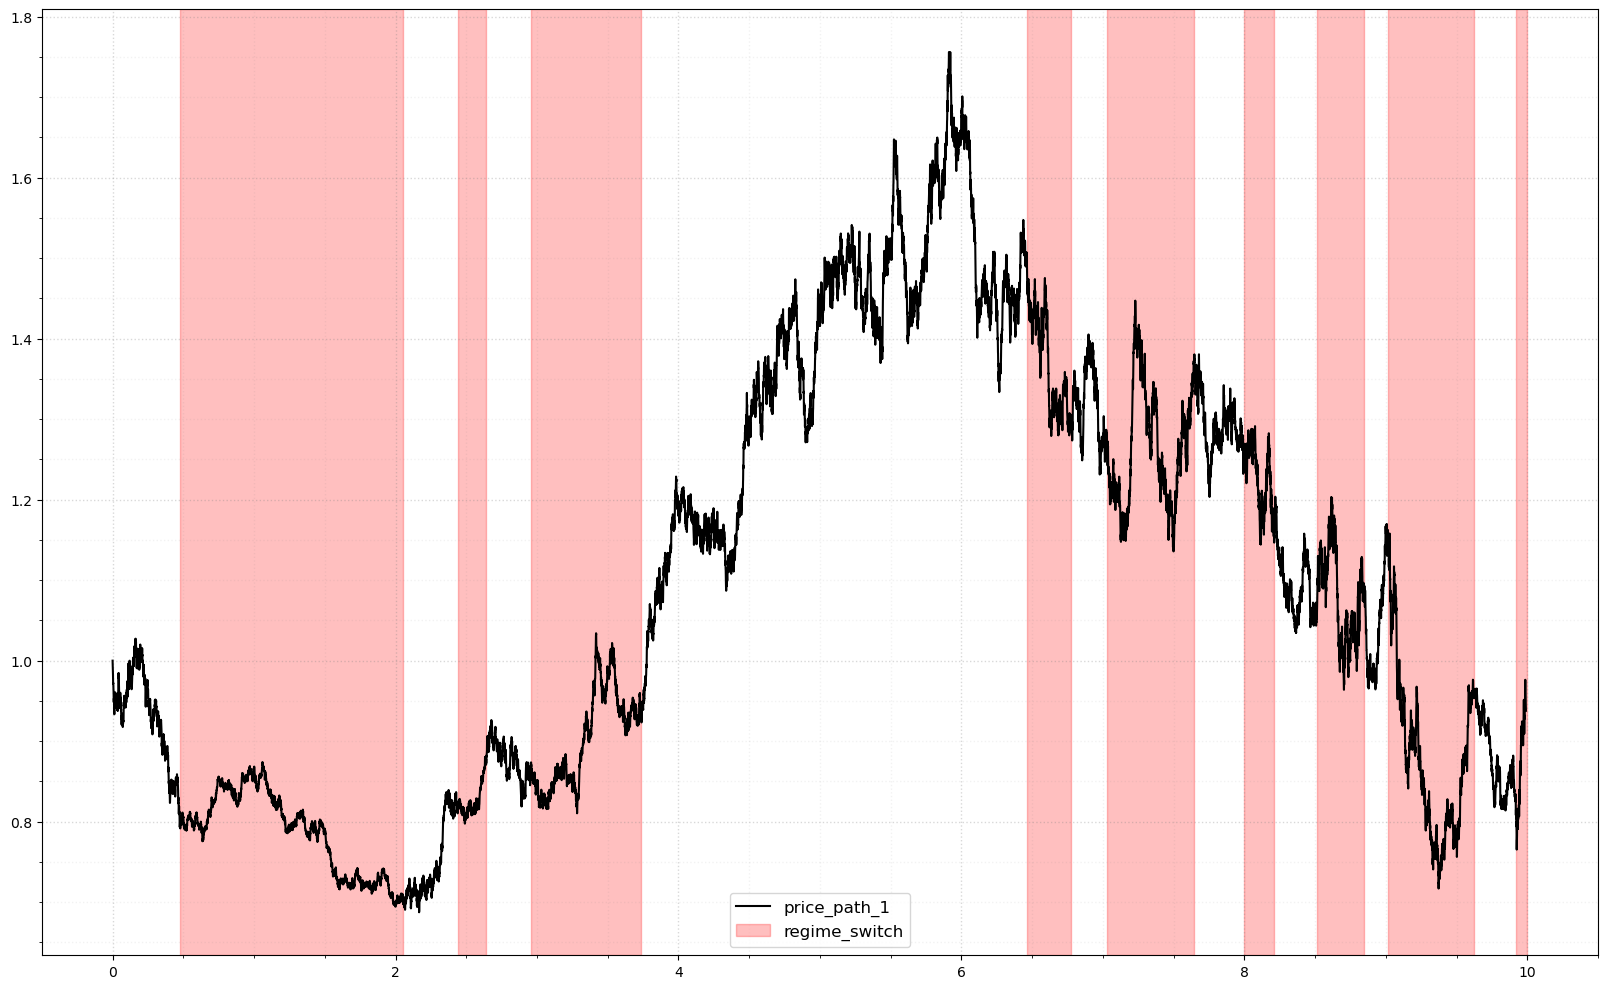

In [6]:
_, regime_changes, _ = regime_partitioner.changes_to_times()

plot_regime_change_path(test_path, regime_changes, log_returns=False, one_dim=True)

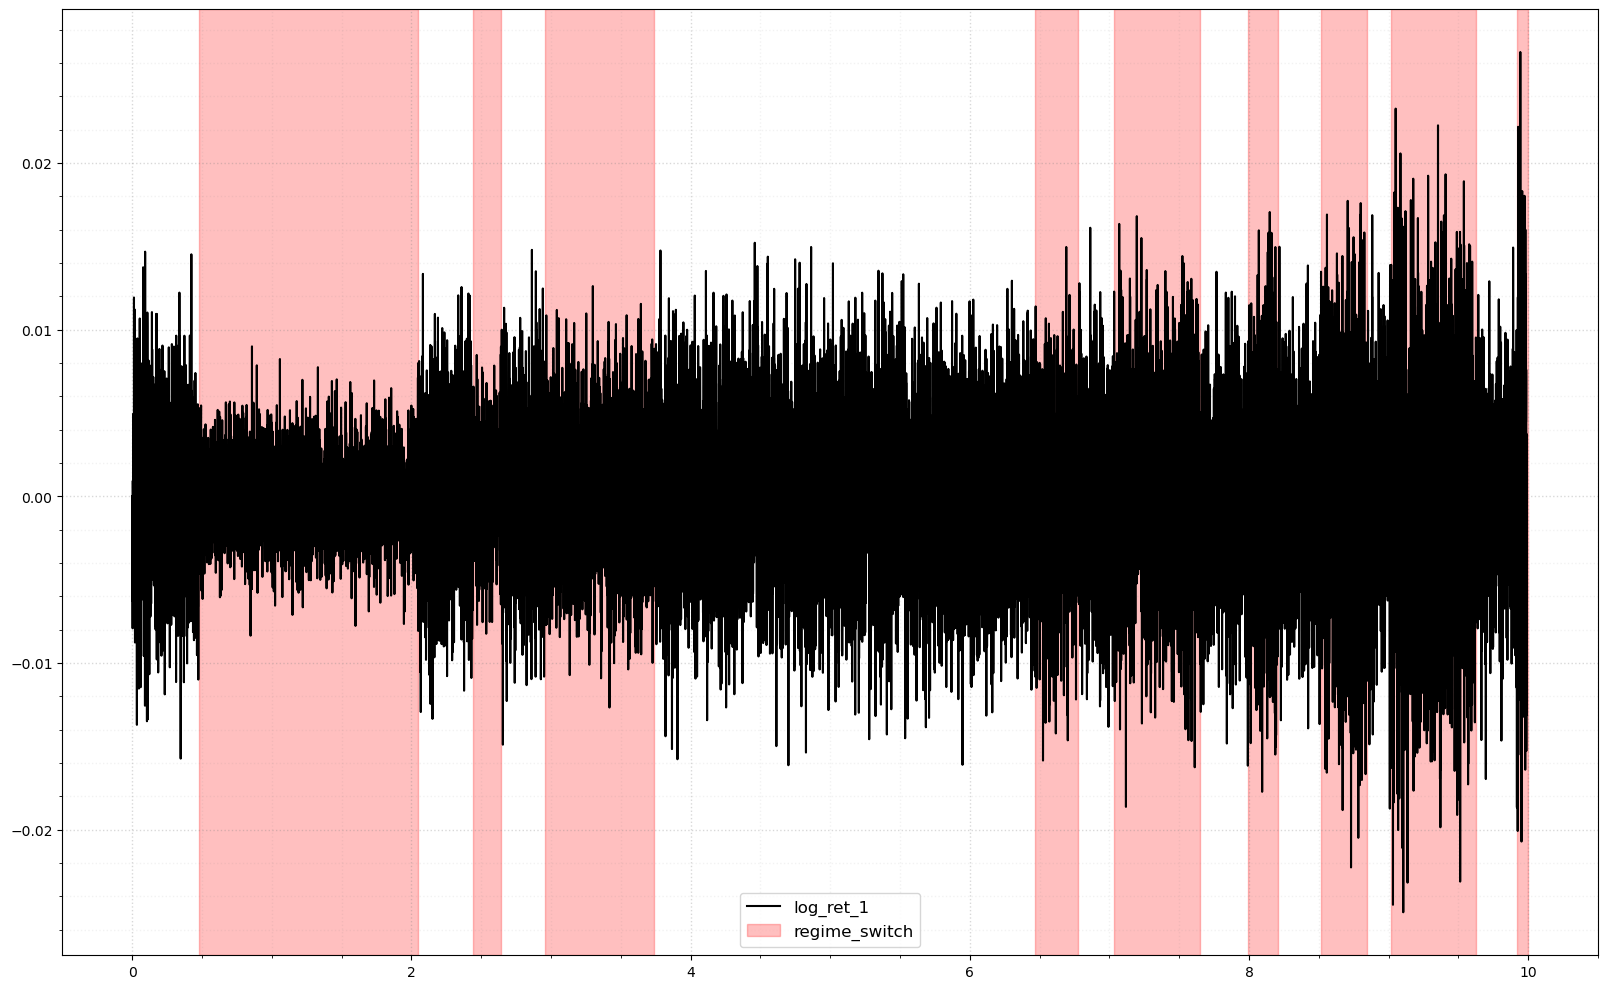

In [7]:
plot_regime_change_path(test_path, regime_changes, log_returns=True, one_dim=True)

In [8]:
multiclass_score_array = sigker_detector.evaluate_path(test_path, evaluation="total")

100%|██████████| 2205/2205 [00:00<00:00, 57537.00it/s]
2190it [00:05, 370.46it/s]
2190it [00:07, 312.73it/s]
2190it [00:06, 341.97it/s]


In [9]:
# Extract sub paths for score functions 
sub_paths = get_sub_paths(test_path, test_config.n_steps, test_config.offset)
c_alpha_g = sigker_detector.critical_value

# Get alpha scores for test thresholds
if processor_config.generalmmddetector_kwargs.metric_kwargs.metric_type == "mmd":
    _n_paths      = test_config.n_paths
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    memberships   = get_memberships(mmd_paths)
    mmd_alphas_g  = get_alphas(memberships, multiclass_score_array, c_alpha_g)
else:
    _n_paths      = 1
    memberships   = np.array([[i] for i in range(sub_paths.shape[0])])
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    mmd_alphas_g  = 1.0*np.array([(gsc >= cv[0]) + (gsc <= cv[1]) for gsc, cv in zip(general_scores_array[1:], c_alpha_g)])

path_splits_time = [item for sublist in [[r[0], r[1] + 1/model_config.year_mesh] for r in regime_changes] for item in sublist] 
path_splits_mesh = [int(p*model_config.year_mesh) for p in path_splits_time]

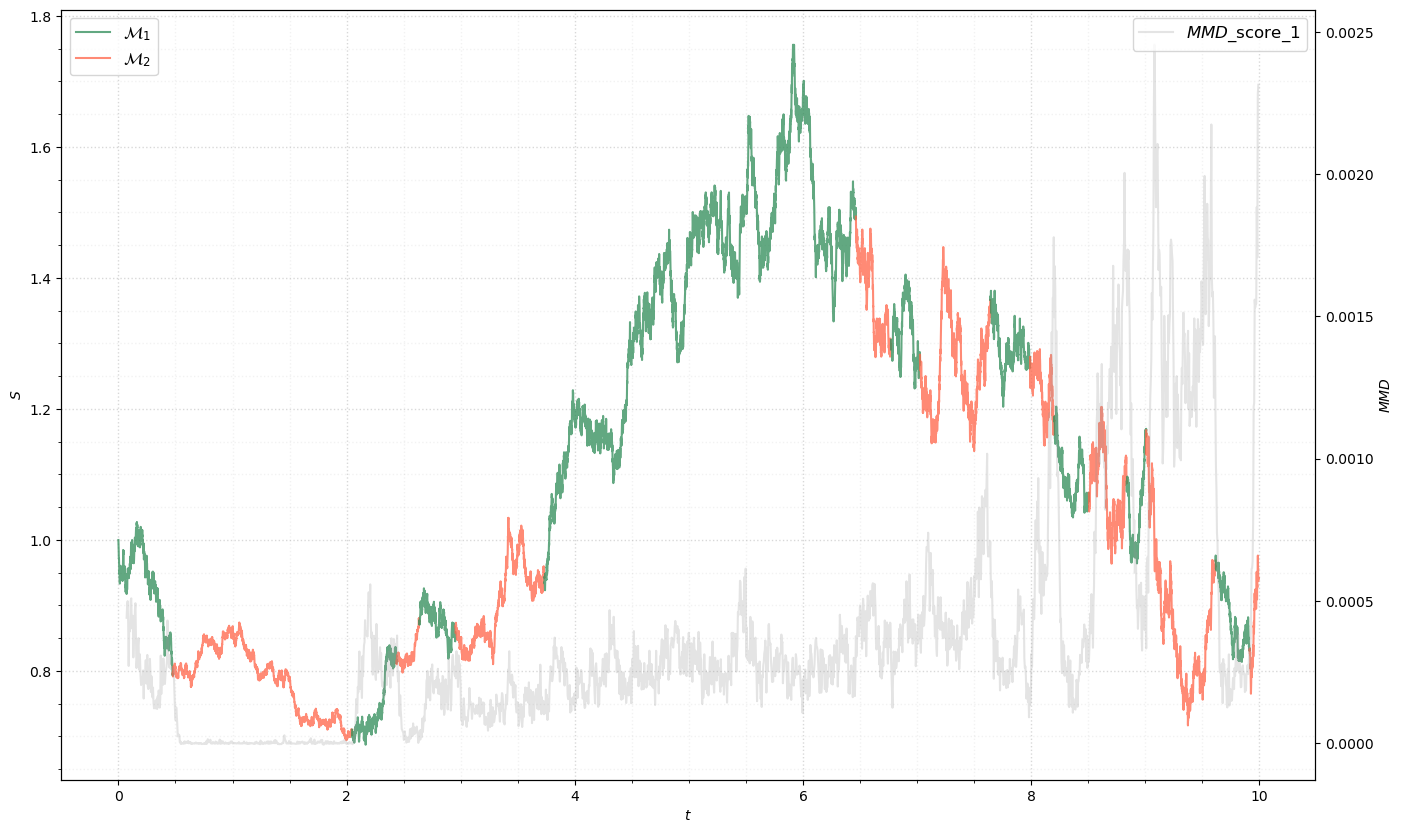

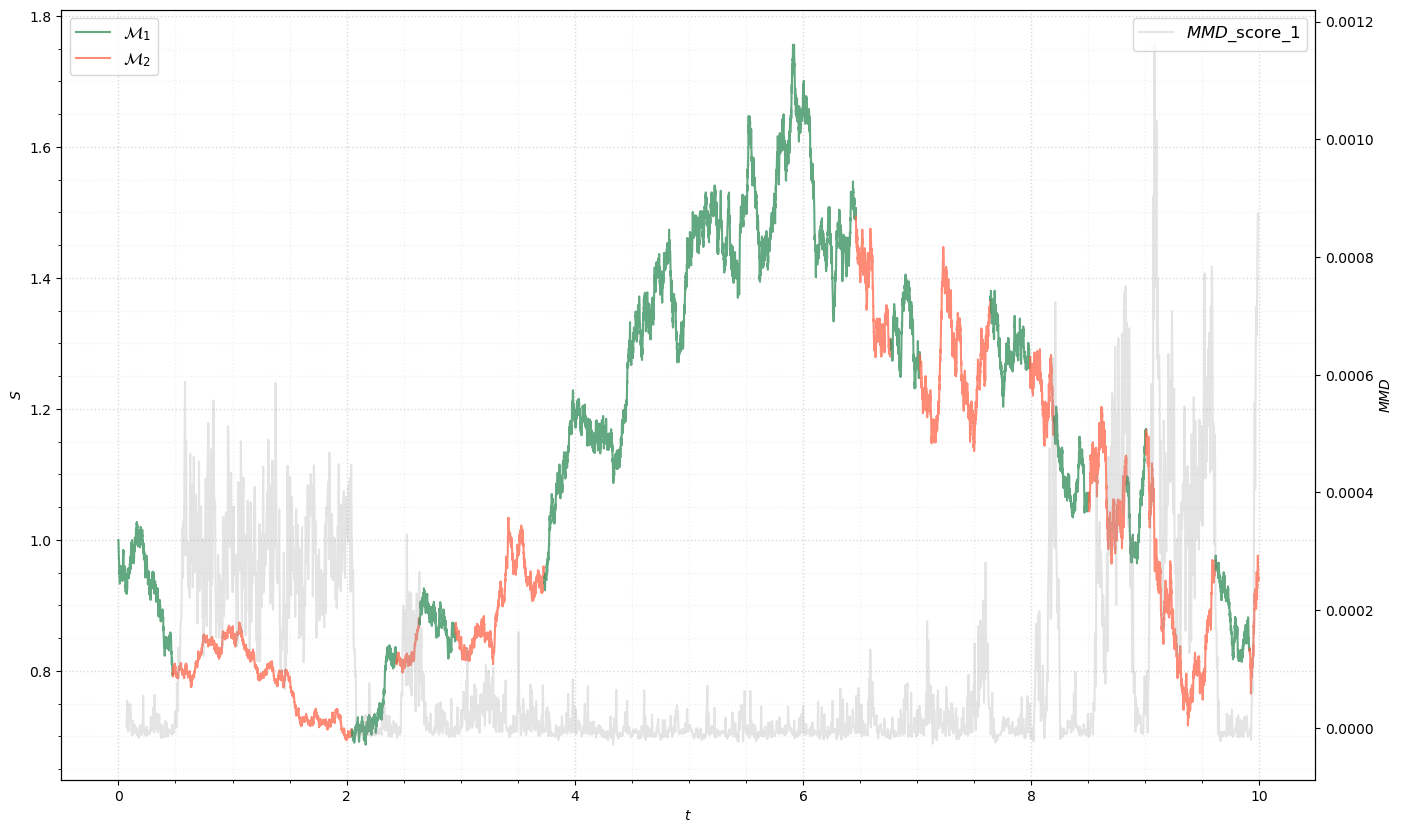

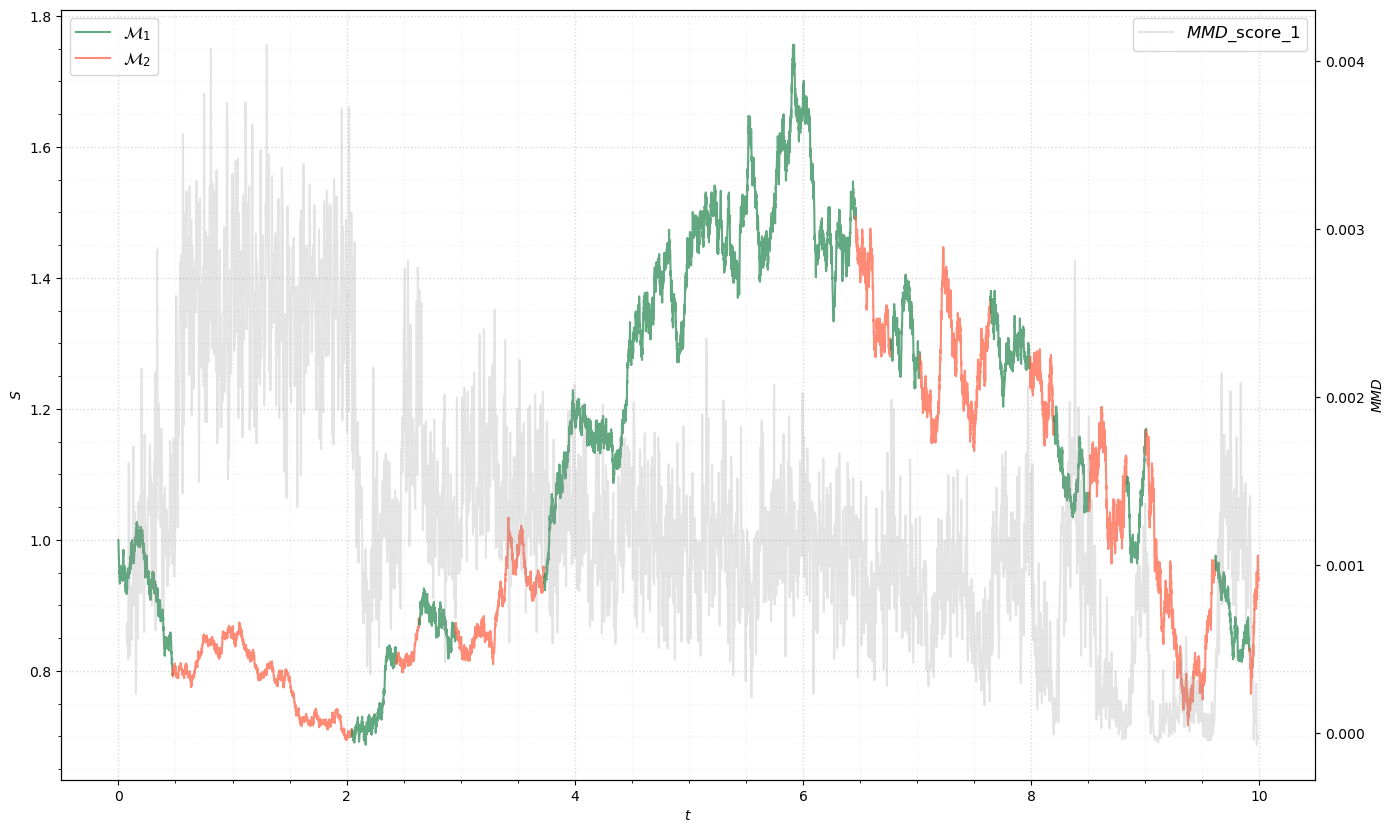

In [13]:
# Plot MMD scores
index = multiclass_score_array[0, :]

for score in multiclass_score_array[1:, :]:
    this_score_array = np.vstack([index, score])
    plot_path_experiment_result(test_path, this_score_array, path_splits_mesh, diff=False)

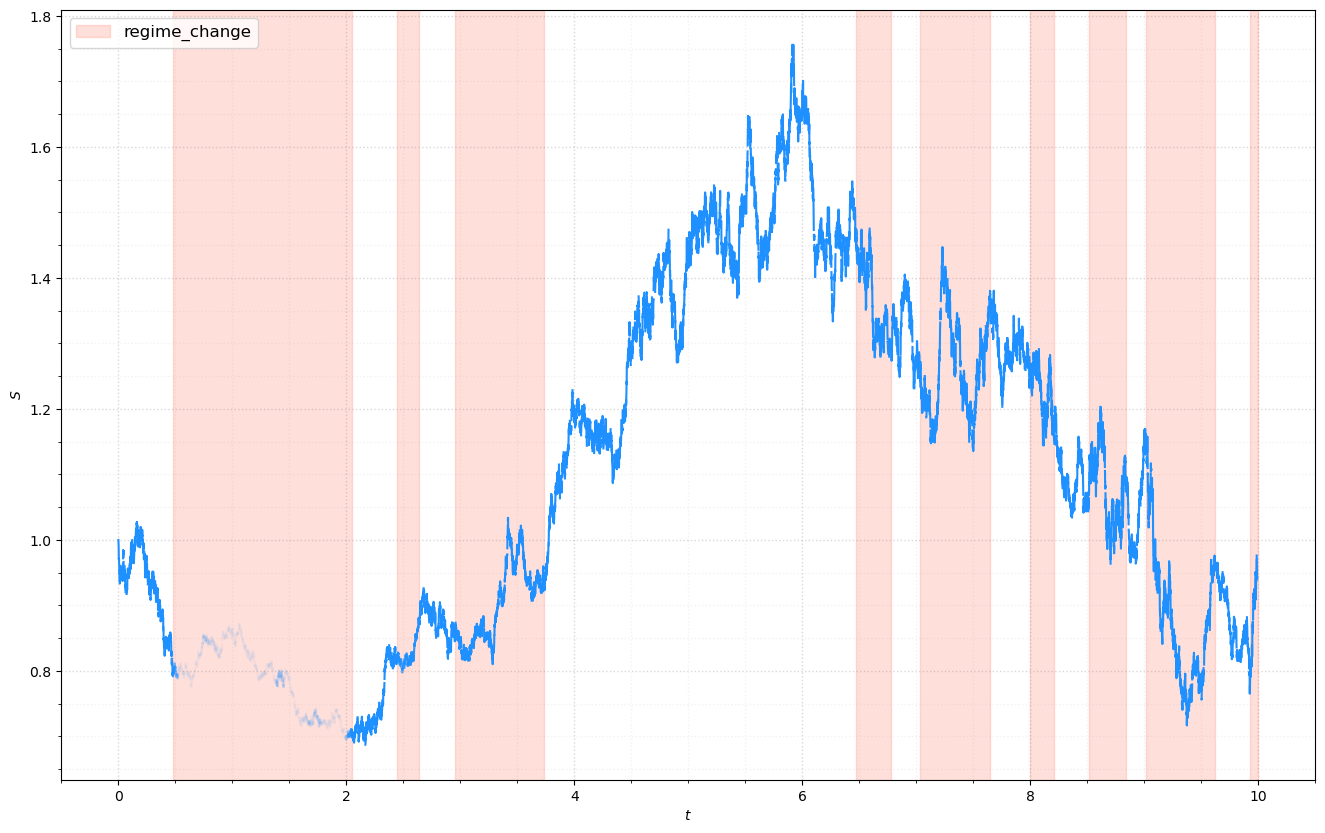

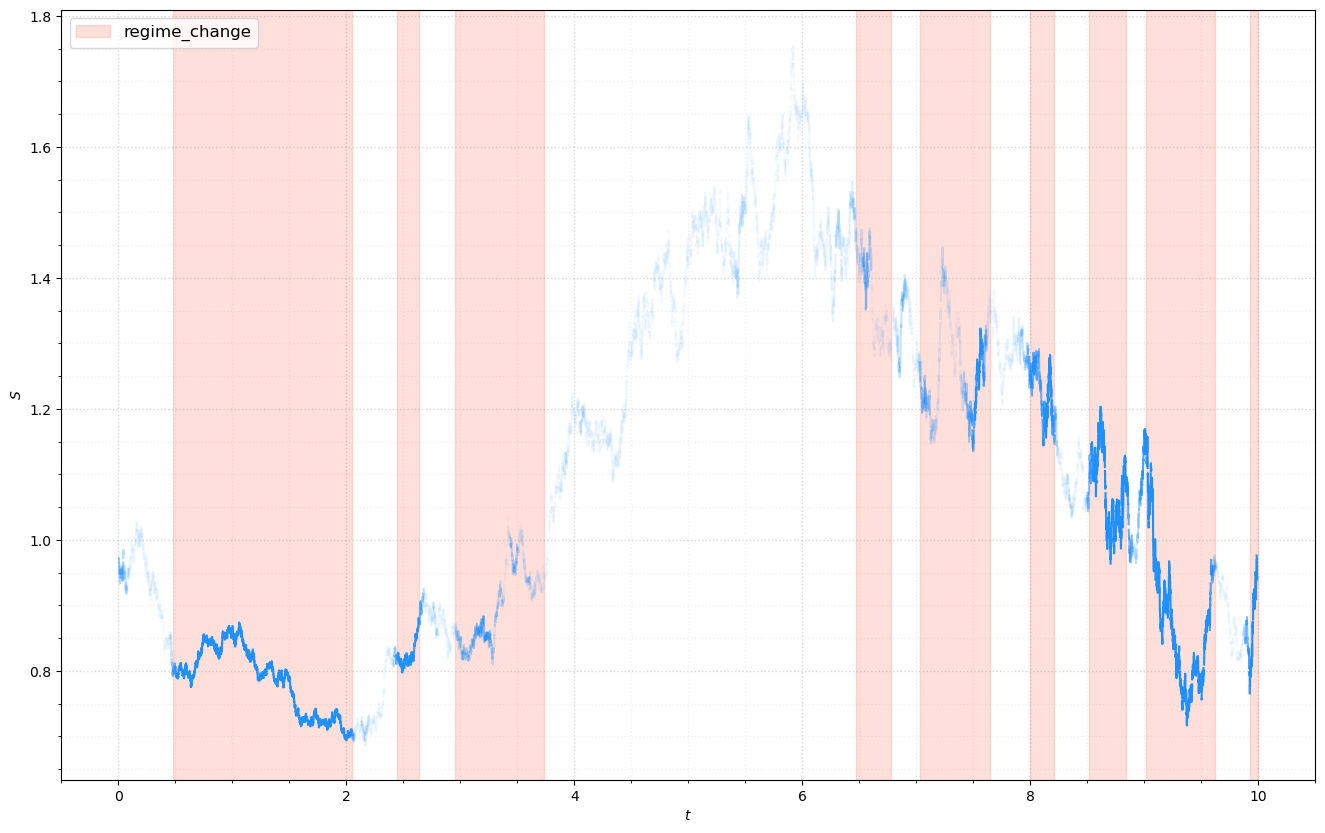

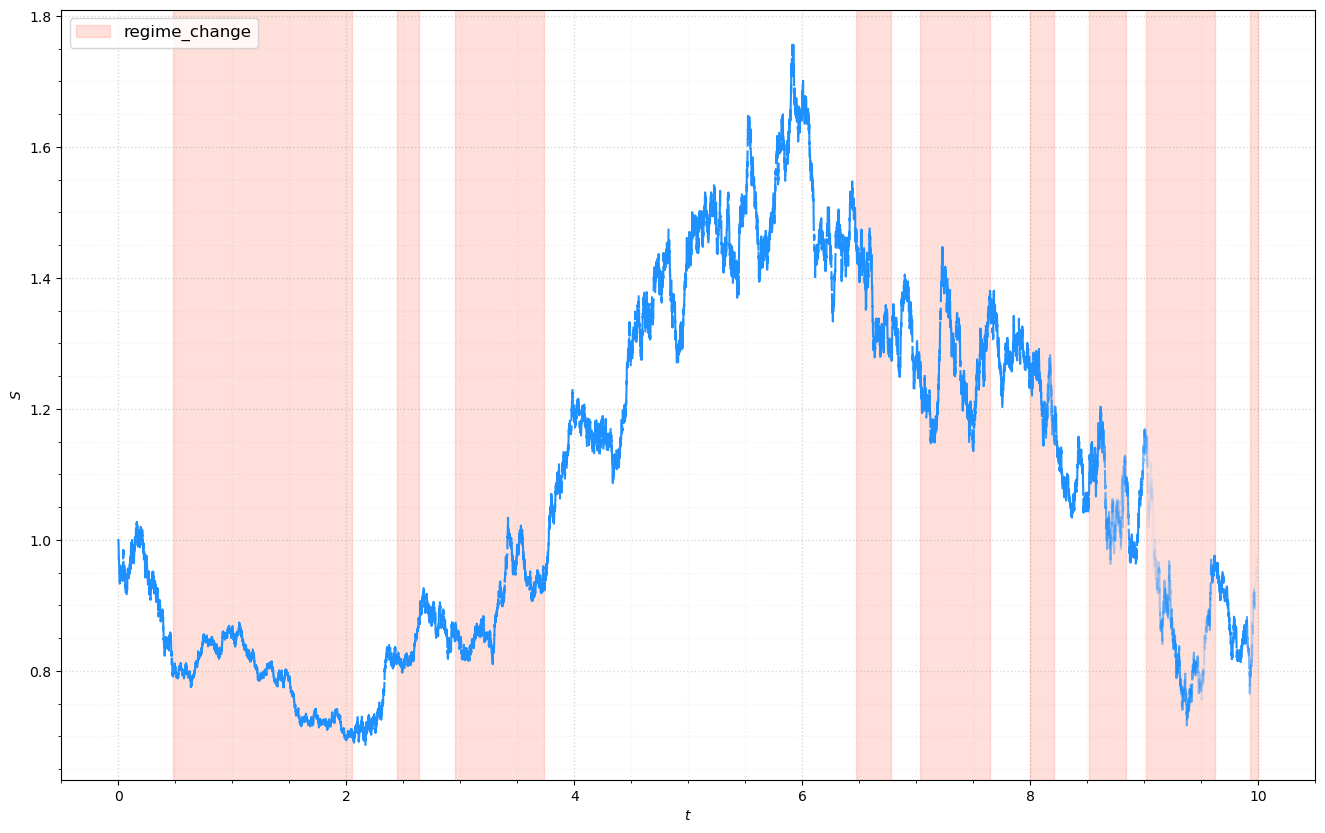

In [11]:
# Plot test threshold performance
for alphas in mmd_alphas_g:
    plot_path_test_threshold(sub_paths, alphas, path_splits_time, one_dim=True)

In [55]:
for i, alph_ in enumerate(mmd_alphas_g):

    this_score_dict = alpha_score_function(
        regime_changes = regime_partitioner.regime_changes, 
        path_length    = len(test_path), 
        memberships    = memberships,
        test_alphas    = alph_,
        test_data      = [test_config.n_steps, test_config.offset, _n_paths]
    )

    print(f"\nSigker scores, belief {i+1}")
    for k, v in this_score_dict.items():
        print("{}: {:.4f}%".format(k, v*100))


Sigker scores, belief 1
regime_on: 68.0081%
regime_off: 0.0000%
total: 36.8879%

Sigker scores, belief 2
regime_on: 87.7611%
regime_off: 94.0721%
total: 90.6490%

Sigker scores, belief 3
regime_on: 65.5043%
regime_off: 0.0000%
total: 35.5298%


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

np.random.seed(1)

num_steps = 1024  # Number of steps in the Brownian motion
delta_t = 0.1  # Time step
t = np.linspace(0, num_steps*delta_t, num_steps+1)  # Time array

# Generate random increments with mean 0 and variance delta_t
increment1 = np.random.normal(0, np.sqrt(delta_t), size=num_steps)
increment2 = np.random.normal(0, np.sqrt(delta_t), size=num_steps)

# Compute the cumulative sums of the increments to get the Brownian motion paths
brownian_motion1 = np.cumsum(increment1)
brownian_motion2 = np.cumsum(increment2)

# Prepend 0 to the Brownian motion paths to start at the origin
bm1 = np.insert(brownian_motion1, 0, 0)
bm2 = np.insert(brownian_motion2, 0, 0)

n_sps = 4
y_max = 128
x_sp = np.sort(np.random.choice(np.arange(num_steps-y_max), size=n_sps, replace=False))
y_sp = x_sp + np.random.randint(8, y_max, size=n_sps)

fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot(t, bm1, bm2, color='dodgerblue', linewidth=2)

# Plot sub paths
ax.scatter(t[x_sp], bm1[x_sp], bm2[x_sp], color="tomato", alpha=0.5)
ax.scatter(t[y_sp], bm1[y_sp], bm2[y_sp], color="tomato", alpha=0.5)

def f_add(t, add):
    return [t, t+add]

def plot_line_segment(sp, add1, add2, add3):
    ax.plot(f_add(t[x_sp][sp], add1), f_add(bm1[x_sp][sp], add2), f_add(bm2[x_sp][sp], add3), linestyle="dashed", color="grey", alpha=0.25)
    ax.plot(f_add(t[y_sp][sp], add1), f_add(bm1[y_sp][sp], add2), f_add(bm2[y_sp][sp], add3), linestyle="dashed", color="grey", alpha=0.25)

adds = [[15, 0, 0], [0, 10, 0], [0, 3, 0], [0, 5, 0]]    

for i, add in enumerate(adds):
    ta, xa, ya = add
    plot_line_segment(i, *add)
    ax.plot(t[x_sp[i]:y_sp[i]] + ta, bm1[x_sp[i]:y_sp[i]] + xa, bm2[x_sp[i]:y_sp[i]] + ya, color="dodgerblue", alpha=0.5)
    
ax.text(102, 10, 6, "$\hat{X}_t$", fontsize=12)
# Set labels and title
ax.set_xlabel('$t$')
ax.set_ylabel('$X_t^1$')
ax.set_zlabel('$X^2_t$')
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Show the plot
plt.show()